In [6]:
! pip install langchain langchain-openai langchain-community langgraph python-dotenv faiss-cpu pypdf

  Using cached tiktoken-0.12.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.4 MB/s  0:00:00 eta 0:00:01
Using cached tiktoken-0.12.0-cp312-cp312-macosx_11_0_arm64.whl (994 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 6.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [langchain-openai][openai]


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [8]:
load_dotenv()

True

In [9]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

In [10]:
loader = PyPDFLoader("btrust.pdf")
docs = loader.load()

In [11]:
len(docs)

3

In [12]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [13]:
len(chunks)

6

In [14]:
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001"
)
vector_store = FAISS.from_documents(chunks, embeddings)

In [15]:
vector_store

In [16]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [17]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [19]:
tools = [rag_tool]
llm_with_tools = model.bind_tools(tools)

In [20]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [21]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [22]:
tool_node = ToolNode(tools)

In [23]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

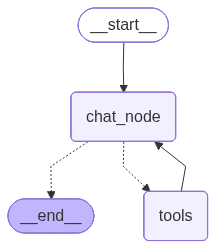

In [24]:
chatbot

In [32]:
config1 = {"configurable": {"thread_id": "1"}}
chatbot.invoke({"messages":[HumanMessage(content="What is the btrust builder tell me as per the pdf")]},config=config1)

ValidationError: 1 validation error for Schema
properties.query
  Input should be a valid dictionary or object to extract fields from [type=model_attributes_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.12/v/model_attributes_type

In [80]:
print(result['messages'][-1].content)

To find the ideal value of \( K \) in the k-nearest neighbors (k-NN) algorithm, follow these steps:

1. **Understand the Role of \( K \)**: The parameter \( K \) represents the number of nearest neighbors to consider when making predictions. A small \( K \) can lead to a model that is sensitive to noise in the data, whereas a large \( K \) can smooth out the decision boundary too much, potentially leading to underfitting.

2. **Choose a Parameter Selection Method**: The most common method for selecting the ideal \( K \) is through grid search, which involves trying a range of values for \( K \) and evaluating their performance. You can use cross-validation to assess the performance of each \( K \).

3. **Set Up Cross-Validation**: Divide your dataset into training and testing subsets, and then perform k-fold cross-validation. This involves splitting the training set into \( K \) smaller sets. For each unique group, you will:
   - Train your model using the other \( K - 1 \) sets.
   - 